# Helsinki City Bikes: Network Analysis
The first part of this article looked at the Helsinki city bike system through the lens of descriptive statistics. In this article, the city bike system will be analyzed as a complex network.

# Introduction
For the past decades, transportation systems are commonly analyzed as networks. This abstraction allows to reduce the amount of information available and focus primarily on the internal structure of the underlying systems.
This idea is certainly not novel in mathematics or urban planning. However, the recent developments in computational technologies and GIS frameworks enabled a new pragmatic application of graph theoretical ideas in the field of transport planning and geographic mobility.

>Within the context of transportation, the term network  refers to the framework of routes within a system of locations, identified as nodes. A route is a single link between two nodes that are part of a larger network that can refer to tangible routes such as roads and rails, or less tangible routes such as air and sea corridors.

Transportation networks normally denote either permanent physical tracks such as roads and railroads or a scheduled service. What makes bike-sharing and car-sharing services special is their ubiquity and possibility for self-organization. Unlike scheduled bus and train services, bike-sharing occurs on-demand and is more spatially flexible. It is crucial to highlight that edges of the city bike network are not predetermined, they are generated by the users. Thus, the structure of the network emerges from the flow of people through the city. Reoccurring trips made by the residents gradually formulate usage patterns and create the structure of the bike-sharing network. This information, in turn, can be used in a feedback loop for the evolution of the network. Rising or decreasing bike demand can provide insights into wider sociological, economical and geographic factors in certain areas.

In [1]:
import datetime
import calendar
import collections
from operator import itemgetter

import numpy as np
import pandas as pd

# Networks 
import networkx as nx
# Community Detection
import community as community_louvain 
import pycombo 

# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

# Interactive Maps/Visaualization
import folium
from folium import plugins
import plotly.graph_objects as go

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

In [2]:
# For Kaggle
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
dataframe = pd.read_csv("/kaggle/input/helsinki-city-bikes/database.csv", low_memory=False)
dataframe.head()
"""

'\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n        \ndataframe = pd.read_csv("/kaggle/input/helsinki-city-bikes/database.csv", low_memory=False)\ndataframe.head()\n'

In [3]:
dataframe = pd.read_csv("data/database.csv", low_memory=False)
dataframe.head()

departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

In [4]:
dataframe[['departure','return']] =  dataframe[['departure','return']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

dataframe = dataframe.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
dataframe = dataframe[ 
                    (50 < dataframe['distance']) & (dataframe['distance'] < 10000) &
                    (120 < dataframe['duration']) & (dataframe['duration'] <  18000) &
                    (-20 < dataframe['temperature']) & (dataframe['temperature'] < 50)        
                    ]

## Creating the Graph object

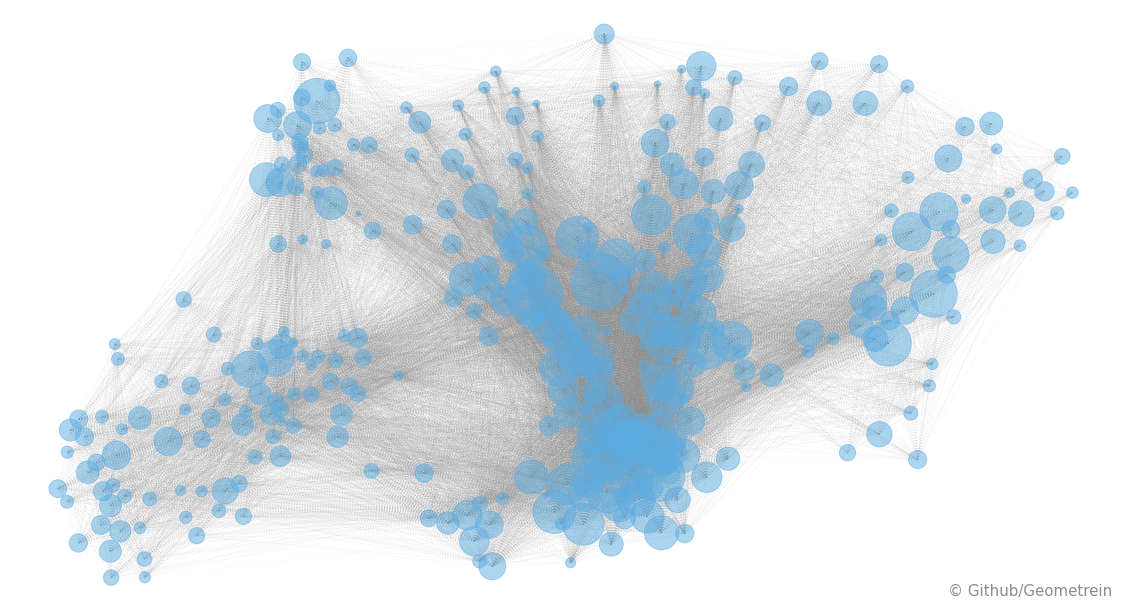

In [5]:
def bikeNetwork(dataframe, year=2020):
    """
    This function plots the City bike network with node sizes illustrating station popularity.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    #print(df.isna().sum())
    
    # Graphs
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])


    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass
    # Draw
    nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
    nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
    ax.axis('off')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return G

G = bikeNetwork(dataframe)

## Basic Network Stats

In [6]:
def networkStats(G):
    """
    This function prints the basic properties of the City bike network.
    """
    print(nx.info(G))
    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)

    degree_dict = dict(G.degree(G.nodes()))
    nx.set_node_attributes(G, degree_dict, 'degree')
    #print(G.nodes['Kamppi (M)'])

    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by degree:\n")
    for d in sorted_degree[:5]:
        print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

networkStats(G)

Name: 
Type: Graph
Number of nodes: 347
Number of edges: 29604
Average degree: 170.6282
Network density: 0.49314520830904035
Triadic closure: 0.7490986589530844

Top 5 nodes by degree:

('Haukilahdenkatu', 312)
('Paciuksenkaari', 272)
('Huopalahdentie', 267)
('Laajalahden aukio', 262)
('Munkkiniemen aukio', 262)

Top 5 nodes by betweenness centrality:

('Haukilahdenkatu', 0.049350760236088746)
('Lehtisaarentie', 0.0071203742710766035)
('Lauttasaaren ostoskeskus', 0.006137945150459285)
('Aalto-yliopisto (M), Korkeakouluaukio', 0.005792495359391806)
('Paciuksenkaari', 0.005688626807042346)


The graph below illustrates bike usage in different areas of Helsinki during 2020. As expected the central Helsinki where most of the economic and cultural value is accumulated is the most active in terms of geographic mobility. However, as pointed out in the first part of this article, the geographic centre of Helsinki and the centre of Helsinki bike network are not the same. Where exactly is the centre of the city bike network?

In [7]:
def mapPlot(dataframe, year = 2020):
    """
    This function prints an interactive bubble plot by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    #df = df[:1000]
    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    #print(df.isna().sum())
    df["name"] = df["departure_name"]
    df = df[["name", "freq"]]
    df = df.drop_duplicates(subset=['name'])
    freq_dict = dict(zip(df.name, df.freq))

    df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
    df_stations = df_stations[df_stations["latitude"]<=60.254011]
    #print(df_stations.head())
    df_stations['freq']= df_stations['name'].map(freq_dict)
    #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
    df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
    df_stations.fillna(1, inplace=True)
    df_stations.dropna(inplace=True)

    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    for index, row in df_stations.iterrows():
        folium.CircleMarker([row['latitude'],row['longitude']],
                        radius=row["freq_adj"],
                        popup=row['freq'],
                        color="#eab544",
                        fill_color="#eab544",
                    ).add_to(hel_map)

    display(hel_map)
    
# function call is commented for performance reasons
mapPlot(dataframe)

In [8]:
def heatMapPlot(dataframe, year = 2020):
    """
    This function prints an interactive heatmap by destination locations for a given year.
    """
    # Data
    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]

    df.dropna(inplace=True)
    df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
    
    # Map
    hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
    folium.TileLayer('cartodbdark_matter').add_to(hel_map)

    stationArr = df[['departure_latitude', 'departure_longitude']].to_numpy()
    hel_map.add_child(plugins.HeatMap(stationArr, radius=15))

    display(hel_map)
    
# function call is commented for performance reasons
#heatMapPlot(dataframe)

# Network Centrality Measures
Complex networks by definition are highly heterogeneous structures. This often results in some parts of the network being more information-rich than others. For example, in social networks, some individuals might have a large number of connections and can spread information faster than others. Hence, within the context of social network analysis, the nodes that represent them are considered more important(central). Within the context of transportation networks, an urban region where the influx of people is higher than in the other areas can be considered central. However, the centrality of a given network may change over time as a result of the growth and evolution of the underlying system. Thus, the definition of centrality is not absolute but rather depends on the specific context and the purpose of the abstraction. Taking this relativity into account, several centrality measures have been proposed that focus on different types of relationships between the nodes.

# Degree Centrality

Degree centrality is the most simple centrality measure to understand and compute. "Degree" of a node refers to the number of nodes that a given node is connected to. Within the context of city bikes, this refers to the number of bike stations that users have travelled to from the target station. As we can see in the graph below stations located in central Helsinki have a higher number of connections. Closer to the periphery of the network the degree of the nodes gradually decreases.


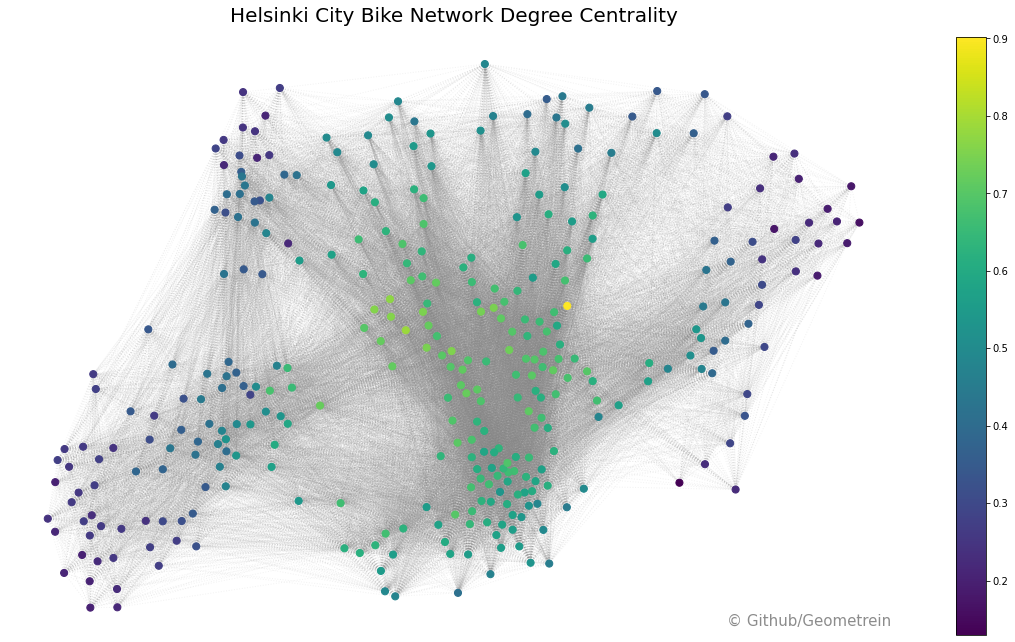

In [9]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityDegree(G)

In [10]:
def centralityDegreeInteractive(G):
    """
    This function plots an interactive network with colorcoded node degrees.
    """
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        opacity=0.4,
        line=dict(width=0.5, color='#888', dash='dot'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='Blues',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(thickness=15,title='Node Connections',xanchor='left',titleside='right'),
            line_width=1))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('Number of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    width=800,
                    height=500, 
                    title='Helsinki City Bike Network 2020',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    paper_bgcolor='rgba(255,255,255,0)',
                    plot_bgcolor='rgba(255,255,255,1)',
                    annotations=[ dict(
                        text="Helsinki",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 )],
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True))
                    )

    fig.show()

# function call is commented for performance reasons
#centralityDegreeInteractive(G)

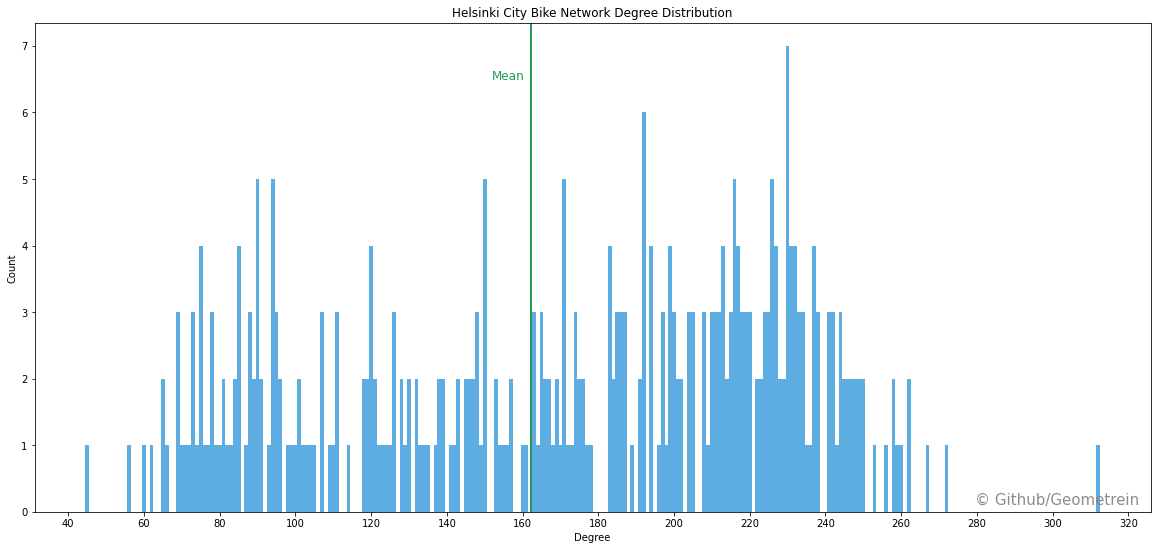

In [11]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
centralityDegreeDist(G)

The average degree of a node in the Helsinki city bike network is 162. This means that a bike station on average is connected to 162 different stations. The stations with the highest centrality degree are:

>Haukilahdenkatu:    312 connections

>Paciuksenkaari:     272 connections

>Huopalahdentie:     267 connections 

>Laajalahden aukio:  262 connections

>Munkkiniemen aukio: 262 connections

>Töölöntulli:        260 connections

>Tilkanvierto:       259 connections

>Paciuksenkatu:      258 connections

>Pasilan asema:      258 connections 

>Esterinportti:      256 connections

The fact that Haukilahdenkatu station is at the top of this list suggests that a large number of citizens from different districts make regular trips to and from this station. This could potentially mean that this station is either next to a large transportation hub or an important point of interest. Quick google search will reveal that it's located across the street from a large educational institution and a work rehabilitation centre. This explains both the regularity of the trips and the inflow of people from different suburban areas.

# Betweenness Centrality

The betweenness centrality captures how much a given node is "in-between" others. This measure calculates the shortest paths between all the nodes of the network and assigns each node a measure based on the number of shortest paths going through the target node. The graph below illustrates the city bike stations by betweenness centrality.

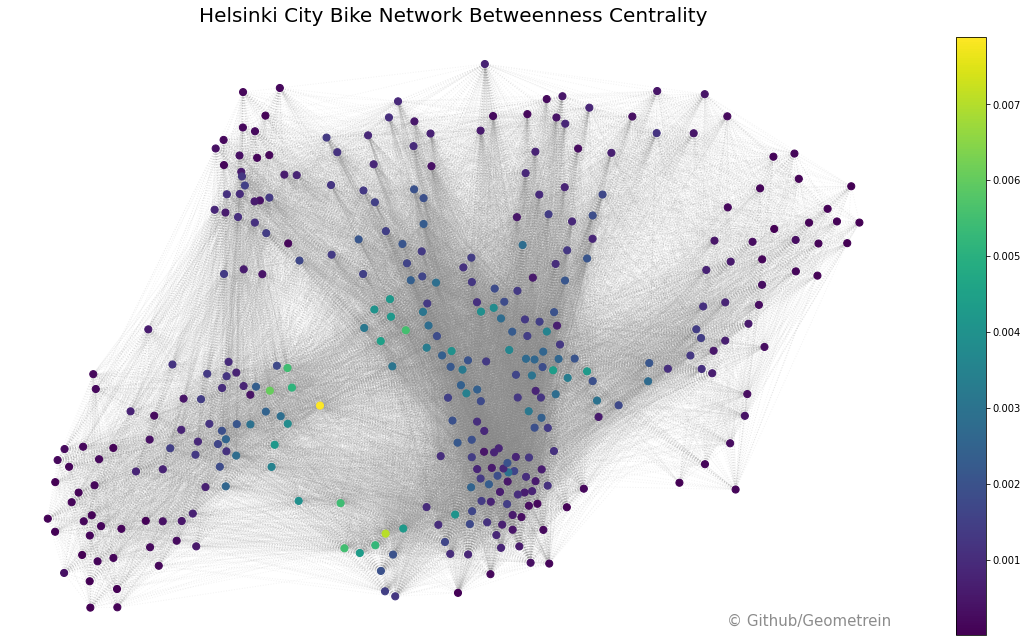

In [12]:
def centralityBetweenness(Graph): 
    """
    This function plots the city bike network betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
    G.remove_node("Haukilahdenkatu")
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityBetweenness(G)

The node with the highest betweenness centrality represents the Lehtisaarentie station. This is a well-saturated example of geographic constraints affecting the structure of spatial networks. The station is located on the Lehtisaari island that links the Aalto University campus to Munkkiniemi and Helsinki. Due to the specificity of the Helsinki archipelago, traffic flows from one municipality to another are mostly channelled through island-bridge systems that lie in between. This makes both Lehtisaari and Lautasarri islands crucial traffic nodes connecting the municipality of Espoo to Helsinki.

# Closeness Centrality
Closeness centrality is a way of detecting nodes that are able to distribute flows efficiently through the network. The closeness centrality is calculated as the normalized average of all of its geodesic distances. Within the context of the city bikes, a node with high closeness centrality will indicate stations that can potentially act as versatile intermediary stations within the network.

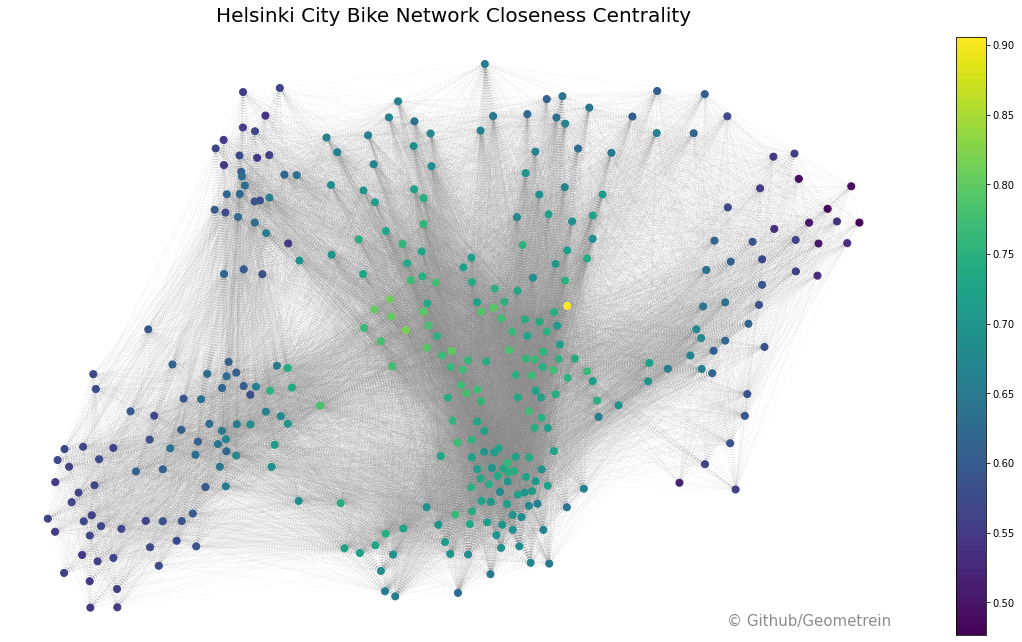

In [13]:
def centralityCloseness(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


centralityCloseness(G)

As illustrated before a large amount of station is directly connected to Haukilahdenkatu station. This leads to Haukilahdenkatu station having the highest closeness centrality within the network. Other nodes with high closeness centrality are located in the areas of Töölo and Pasila. Closeness centrality might be interesting metrics for network optimization, especially for larger networks. In larger bike-sharing networks users might be motivated to make stops at the intermediary bike stations to avoid extra charges. However, as we have seen in the previous part of this article long trips are not common in Helsinki.

# Eigenvector centrality & PageRank
Eigenvector centrality measures a node's importance within the network while giving consideration to the importance of its neighbours. Connections to high-scoring eigenvector centrality nodes contribute more to the score than equal connections to low-scoring nodes. In other words, a node with a large number of connections may have a low Eigenvector score if all of its connections are with low-score nodes. A popular variation of eigenvector centrality is Google's PageRank. In essence, PageRank is a variation of normalized eigenvector centrality combined with random jumps. Thus it is not surprising that Pagerank yields result comparable to Eigenvector(graphs below). With this method, stations like the Central Railway Station, Pasila, Lehtisaarentie and Haukilahdenkatu appear as central nodes within the network.

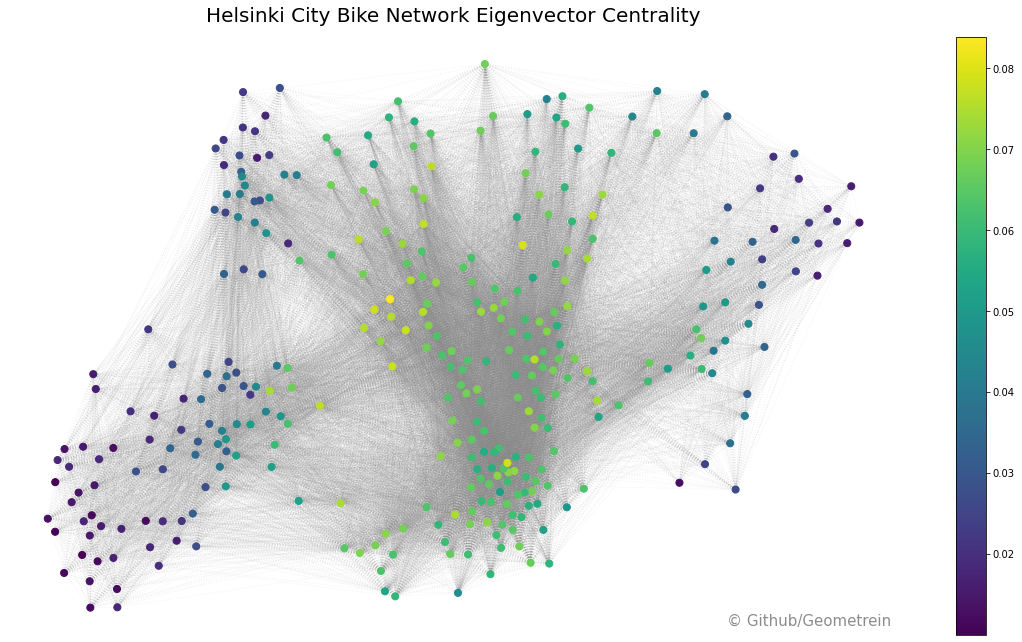

In [14]:
def centralityEigenvector(G):
    """
    This function plots the city bike network Eigenvector centrality
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    eigenvector = nx.eigenvector_centrality(G, max_iter=6000, weight="duration")
    node_color = [eigenvector[i] for i in eigenvector.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Eigenvector Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityEigenvector(G)

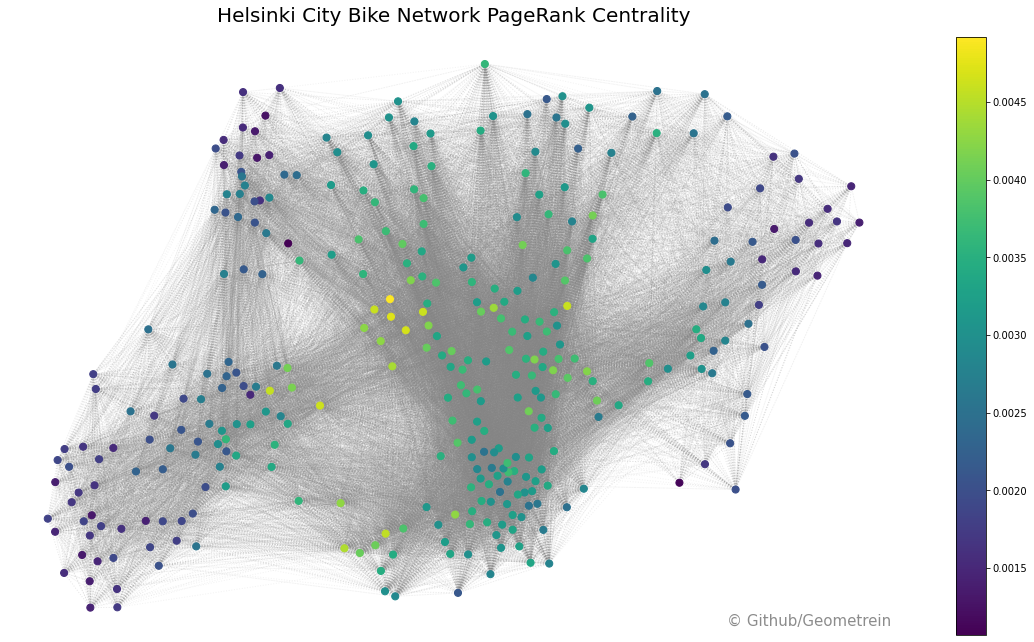

In [15]:
def centralityPageRank(dataframe, year=2020):
    """
    This function plots the city bike network nodes by PageRank
    """

    df = dataframe.copy()
    df = df[df['departure'].dt.year == year]
    df.dropna(inplace=True)
    
    # Directed Graph
    G = nx.Graph()
    G = nx.from_pandas_edgelist(df, source='departure_name', target='return_name', edge_attr=['duration','distance'], create_using=nx.DiGraph())
    
    # Positions
    stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
    stantions.set_index('name',inplace=True)
    stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
    pos = stantions.to_dict()['pos']

    # Map "pos" atribute to nodes from pos dict
    for node, position in pos.items():
        try:
            G.nodes[node]['pos'] = position
        except KeyError:
            pass

    # Phagerank
    phagerank = nx.algorithms.link_analysis.pagerank_alg.pagerank(G, weight="duration")
    node_color = [phagerank[i] for i in phagerank.keys()]

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Color Scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network PageRank Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

centralityPageRank(dataframe) 

The application of eigenvector and PageRank in an urban context is a subject of ongoing debate. It has been suggested that these metrics applied in an urban context often lead to misleading results since they ignore a multitude of urban qualities that might contribute to the importance of the node within the city. Some methods to overcome this issue propose adding an increasing amount of information to the graphs. This is a questionable approach since adding an increasing amount of information will inevitably introduce new arbitrary patterns within the data. Thus, these approaches often blur the clarity achieved by the act of abstraction creating a clear anti-pattern.

 While the limitation of Eigenvector centrality to capture urban qualities might be a problem in collective transportation systems where the routes of the services are predetermined, this is certainly not the case with individual transportation. As mentioned before, the structure of individual transportation networks is generated by the users therefore it already has the information about the urban qualities embedded in it. The fact that users have a choice and choose to take one path instead of the other creates a trivial voting mechanism that rates different areas of the city. Thus, in this kind of networks, the study of the structure of the network is also a study of user behaviour and their preferable urban qualities. Additionally, Eigenvector centrality in individual transportation networks allows highlighting not only important singular nodes but also geographically important areas within the city. This is possible because it acknowledges not only the importance of individual station but also the importance of stations adjacent to them. Eigenvector centrality illustrates that importance in the city bike stations(nodes) is derived no so much from their inherent attributes(location, station size) but rather from their relationships with other nodes within the network. Central stations together with nodes adjacent to them form small enclaves of activity. The identification of this kind of groupings of nodes within the context of complex networks is commonly referred to as community detection.

# Community Detection
Communities in networks refer to groups of nodes that are densely connected internally. Community detection is often a crucial process for understanding the structure of complex networks. In the case of the city bike network, community detection can help to better understand bike usage patterns and determine adequate pricing models. There is a number of algorithms available for community detection.

# Combo Method
The majority of exiting community detection strategies iteratively perform one of the following operations: merging two small communities, splitting a large community into two, moving nodes between two distinct communities. The Combo algorithm developed at MIT sensible city lab compounds all three strategies into a sequence. After creating an initial single community, for each source community, the best possible redistribution of all source nodes is calculated then the best grouping is applied. These steps are iteratively repeated until the given fitness criteria are achieved. The graph below illustrates the Combo method applied to the Helsinki city bike network.

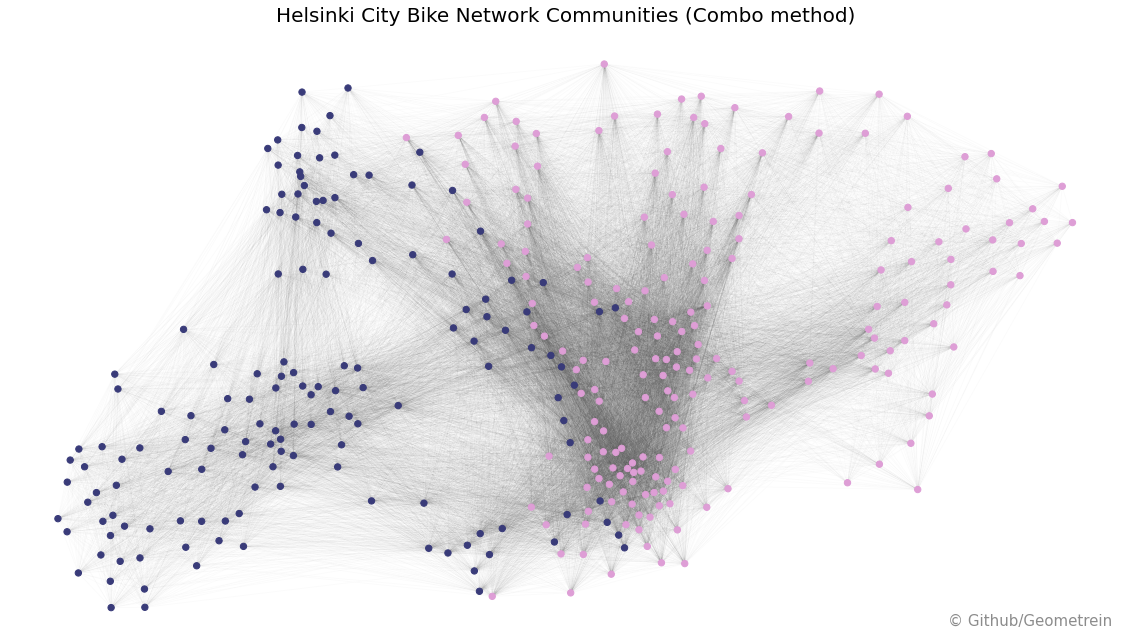

In [16]:
def communityCombo(G):
    """
    This function applies the Combo method for community detection on the City bike network.
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Partition
    partition, modularity = pycombo.execute(G, return_modularity=True, modularity_resolution= 1,  weight="duration", max_communities=2, random_seed=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Combo method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

communityCombo(G)

This grouping reveals two distinct communities that are separated approximately in line with the exiting municipality divisions. This is perhaps not extremely informative since this division could have been assumed merely by looking at the map. Based on the first part of this article, intuitive understanding suggests that bikes are more likely to be used inside the municipalities on shorter distances. Therefore if other communities exist they should be found on a more local scale.

# Louvain Method
Since the previous community detection method did not yield insightful results we can apply a different method that only focuses on the modularity of the network. The Louvain community detection algorithm is chosen due to its beautiful simplicity and the resulting ease of implementation/computation. It allows circumventing the NP-complete problem of maximum cuts in Graphs. Applying the Louvain method to the Helsinki city bike network reveals four distinct communities.

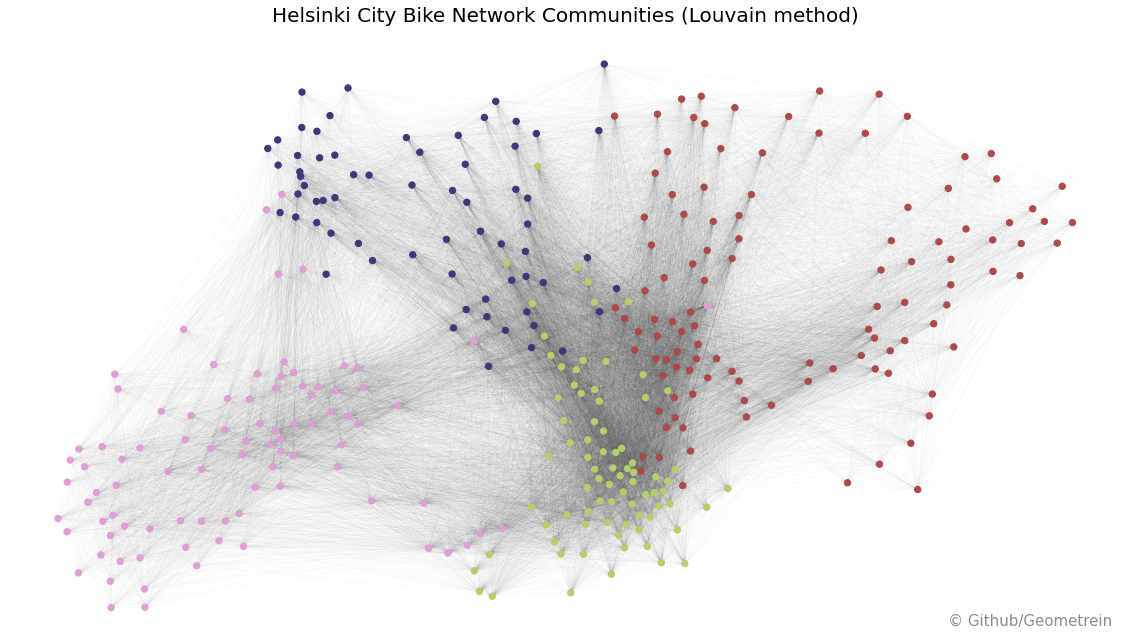

In [17]:
def communityLouvain(G):
    """
    This function applies the Louvain method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Louvain method
    partition = community_louvain.best_partition(G, resolution=0.95, random_state=1)

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Louvain method)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityLouvain(G)

This means that bike usage inside these four communities is higher than the bike usage between these communities. Nodes with high betweenness centrality are usually the places where the communities might be divided into modules. If we return to our betweenness centrality graph this relationship will become even more evident. Boundaries of the communities pass roughly through the nodes with high betweenness centrality. Also, this division doesn't come as a surprise taking into account the geographic character of the Helsinki archipelago. Landmasses and their divisions by large bodies of water significantly affect community formation. It is important to highlight that all transportation networks are spatial networks and their structure and evolution are closely intertwined with physical constraints. An interesting discovery is that the Leppavara area, despite being part of Espoo municipality, is more densely connected to Munkiniemi and Pitäjänmaki than to Otniemi or Tapiola areas. A similar tendency can be seen in some stations around Sörnäinen where stations are more densely connected to the Herttoniemi area.

## Fluid Communities Method
The Fluid Communities algorithm is a community detection algorithm based on the idea of introducing a number of fluids within a non-homogeneous environment, where fluids will expand and push each other influenced by the topology of the environment until a stable state is reached. The algorithm does the following. First, it defines each of the starting communities in a random node of the graph. Then the algorithm iterates over all nodes in a random order, updating the community of each node based on its own community and the communities of its neighbours. This process is performed iteratively until convergence.

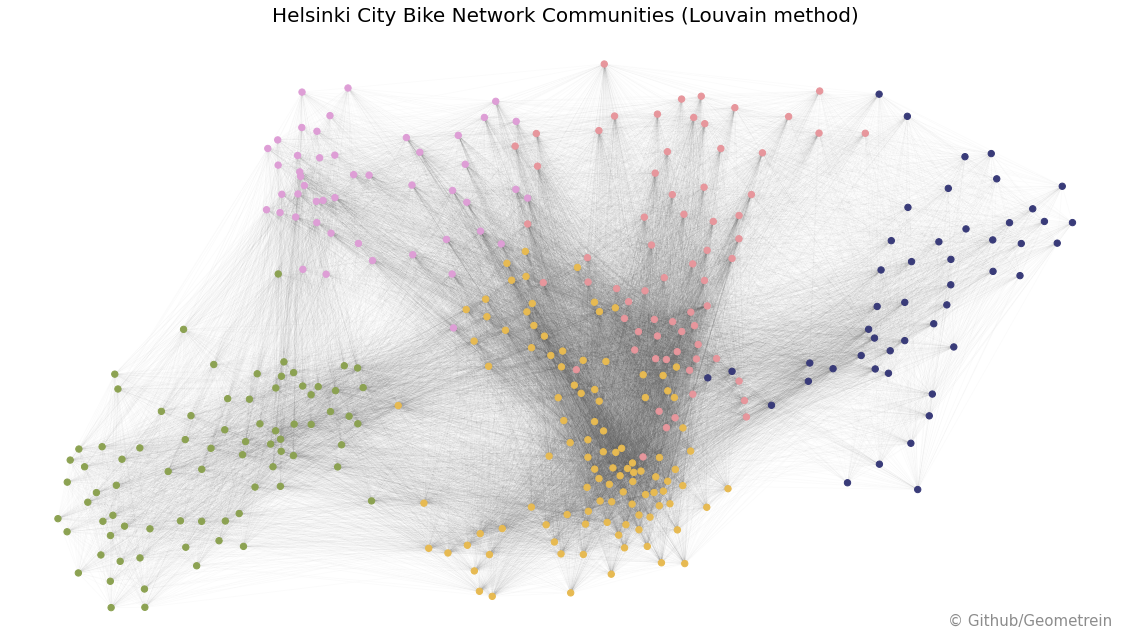

In [40]:
def communityFluid(G):
    """
    This function applies the Fluid Communities method for community detection on the City bike network.
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    # Compute Fluid method
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(G, k=5, max_iter=10000, seed=1)
    
    # Assigning each node to its cluster
    partition = {}
    for idx, val in enumerate(communities):
        for k in val:
            partition[k] = idx

    # Partition colormap
    cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)

    # Draw Nodes & Edges
    nx.draw_networkx_nodes(G, G.nodes.data('pos'), partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, G.nodes.data('pos'), alpha=0.015)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Communities (Fluid Communities)', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityFluid(G)

We can see that the Fluid community detection method confirms the communities identified with the Louvain method and identifies one additional community. 
- Eastern Espoo(Magenta Community) is a distinct community shaped by geographic constraints and extending along the metro line towards the West. 
- Leppävaara, Pitäjanmaki, Munkiniemi, and Etelä Haaga (Green Community) form another cycling community despite the municipality divisions separating the districts.
- The areas of Vallila, Kapyla and Oulunkylä form another group(Pink Community) separated from the Green community by Central Park. This community is stretched along the railroad in northern Helsinki.
- The southern part of Helsinki (Blue Community) includes the geographic centre of Helsinki and major stations such as Kammpi, central railway station and extends towards the southern shoreline.
- Meanwhile, Herttoniemi is at the centre of another enclave (Yellow Community) that extend from Sornainen to Vuosaari along the metro line.

## Conclusion
In this part of the article, the Helsinki city bike network was briefly analyzed as a complex network. Multiple centrality measures were applied to the network and important centres were identified. Tree community detection algorithms revealed different possible groupings of the nodes within the network. The next part of the article will take a look at how machine learning methods can be applied to further enhance understanding of relationships within the network.